In [ ]:
import numpy as np
# import pandas an pd
import math
import dlib
import matplotlib.pyplot as plt
import pickle
import copy
import random
import math
from scipy import interpolate
"""TPS"""
import copy
from google.colab import drive
drive.mount('/content/gdrive')
import cv2
from google.colab.patches import cv2_imshow

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def getFacialFeatures(image):

  dup_image=image.copy()
  gray = cv2.cvtColor(dup_image, cv2.COLOR_BGR2GRAY)
  hog_face_detector = dlib.get_frontal_face_detector()
  dlib_facelandmark = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat")
  faces = hog_face_detector(gray)
  # print(faces)
  # print(faces)  Output: rectangles[[(194, 624) (452, 882)], [(968, 538) (1226, 796)]]
  face_landmarks_li=[]
  face_points = [] 
  for face in faces:
    fp = np.zeros((68,2))
    face_landmarks=dlib_facelandmark(gray,face)
    face_landmarks_li.append(face_landmarks)
    for i in range(0,68):
      x=face_landmarks.part(i).x
      y=face_landmarks.part(i).y
      fp[i,0] = x
      fp[i,1] = y
      cv2.circle(dup_image,(x,y),2,(0,0,255),-1)
    face_points.append(fp)
  return dup_image, face_landmarks_li, faces, face_points


def U(z):
  x = z[0]
  y = z[1]
  r = np.sqrt(x**2 + y**2)
  return (r**2)*(math.log(r**2+10e-6))

def TPS(source, destination,xORy):
  P = np.ones((len(source),3))
  for i in range(len(source)):
    P[i,1] = source[i][0]
    P[i,2] = source[i][1]
  # print("Thin Plate Spline")
  K = np.zeros(((len(source),(len(source)))))
  for i in range(len(source)):
    for j in range(len(source)):
      K[i,j] = U(source[i] - source[j])
  P_tp = P.transpose()
  L_intermediate = np.zeros((71,71))
  L_intermediate[:68,:68] = K
  L_intermediate[68:,:68] = P_tp
  L_intermediate[:68,68:] = P
  L_intermediate[68:,68:] = np.zeros((3,3))
  I = np.identity(L_intermediate.shape[0])
  lamb = 250
  # print(I.shape, L_intermediate.shape)
  L = L_intermediate + lamb*I
  LInv = np.linalg.inv(L)
  V = np.zeros((len(destination)+3,1))

  if (xORy == 'x'):
    for i in range(len(destination)):
      V[i] = destination[i][0]
  elif(xORy == 'y'):
    for i in range(len(destination)):
      V[i] = destination[i][1]


  weights = np.matmul(LInv,V)
  # print(f"weights shape = {weights.shape}")
  return weights, K


def face_values(faces_rectangle, base_img):
    img = base_img.copy()
    face1_rectangle = faces_rectangle[0]
    x_range_min,x_range_max = face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max = face1_rectangle.top(),face1_rectangle.bottom()

    face2_rectangle = faces_rectangle[1]
    x2_range_min,x2_range_max = face2_rectangle.left(),face2_rectangle.right()
    y2_range_min,y2_range_max = face2_rectangle.top(),face2_rectangle.bottom()

    point_matrix_face_1=[]
    for x in range(x_range_min,x_range_max+1):
        for y in range(y_range_min,y_range_max+1):
            point_matrix_face_1.append([x,y])
    point_matrix_face_1 = np.array(point_matrix_face_1)

    point_matrix_face_2=[]
    for x in range(x2_range_min,x2_range_max+1):
        for y in range(y2_range_min,y2_range_max+1):
            point_matrix_face_2.append([x,y])
    point_matrix_face_2 = np.array(point_matrix_face_2)

    return point_matrix_face_1, point_matrix_face_2



def FXtoY(point_matrix_face_1,point_matrix_face_2, f1_points, f2_points, weights, flag):
    uu1 = np.zeros((len(f1_points),len(point_matrix_face_1)))
    sx = f2_points[:,0]
    sy = f2_points[:,1]
    vx = f1_points[:,0]
    vy = f1_points[:,1]
    if(flag == 'onetotwo'):
      for i in range(len(f1_points)):
        for j in range(len(point_matrix_face_1)):
          uu1[i,j] = U(f1_points[i]-point_matrix_face_1[j])
      # print("lol",uu1.shape)
      print(uu1.transpose().shape)
      for i in range(len(f1_points)):
        f1 = weights[-1] + weights[-3]*vx[i] + weights[-2]*vy[i] + np.matmul(uu1.transpose(), weights[:-3])
        return f1

    elif(flag == 'twotoone'):
        uu2 = np.zeros((len(f2_points),len(point_matrix_face_2)))
        for i in range(len(f2_points)):
          for j in range(len(point_matrix_face_2)):
            uu2[i,j] = U(f2_points[i]-point_matrix_face_2[j])
        # print("lol",uu2.shape)
        print(uu1.transpose().shape)
        for i in range(len(f2_points)):
          f2 = weights[-1] + weights[-3]*vx[i] + weights[-2]*vy[i] + np.matmul(uu2.transpose(), weights[:-3])
        return f2

def mask_from_points(size, points,erode_flag=1):
    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(np.int32(points)), 255)
    if erode_flag:
        mask = cv2.erode(mask, kernel,iterations=1)

    return mask


def Inter(Fx,Fy, point_matrix_face_1, mask_face,Fx_2,Fy_2,point_matrix_face_2,mask_face_2,base_img,faces_rectangle,f1_points,f2_points):
    temp_img = base_img.copy()
    height,width,_= base_img.shape
    x=np.arange(width)
    y=np.arange(height)

    interpolate_function_X = interpolate.interp2d(x, y, base_img[:,:,0])
    interpolate_function_Y = interpolate.interp2d(x, y, base_img[:,:,1])
    interpolate_function_Z = interpolate.interp2d(x, y, base_img[:,:,2])
  
    zX = []
    zY = []
    zZ = []
    for x,y in zip(Fx,Fy):

        # print(x_dest,y_dest)
        z_x = interpolate_function_X(x,y)
        zX.append(z_x)
        z_y = interpolate_function_Y(x,y)
        zY.append(z_y)
        z_z = interpolate_function_Z(x,y)
        zZ.append(z_z)
    zX = np.array(zX)
    zY = np.array(zY) 
    zZ = np.array(zZ)

    for idx in range(len(point_matrix_face_1)):
      x, y = point_matrix_face_1[idx]
      if mask_face[y,x]>0:
        
        z_x = zX[idx]
        z_y = zY[idx]
        z_z = zZ[idx]
        # print(z_x)
        temp_img[y,x,0] = z_x
        temp_img[y,x,1] = z_y      #x,y
        temp_img[y,x,2] = z_z      #y,x  

    face2_rectangle=faces_rectangle[1]
    x_range_min,x_range_max = face2_rectangle.left(),face2_rectangle.right()
    y_range_min,y_range_max = face2_rectangle.top(),face2_rectangle.bottom()

    src = base_img[y_range_min:y_range_max,x_range_min:x_range_max]   
    dst=temp_img.copy()

    face1_rectangle = faces_rectangle[0]
    x_range_min, x_range_max = face1_rectangle.left(), face1_rectangle.right()
    y_range_min, y_range_max = face1_rectangle.top(), face1_rectangle.bottom()

    center=(int((y_range_min+y_range_max)/2),int((x_range_max+x_range_min)/2))
    mask = mask_from_points((src.shape[0],src.shape[1]), f2_points, erode_flag=0)
    temp_img = cv2.seamlessClone(src, dst, mask, tuple(center), cv2.NORMAL_CLONE)

    zX = []
    zY = []
    zZ = []
    for x,y in zip(Fx_2,Fy_2):

        # print(x_dest,y_dest)
        z_x = interpolate_function_X(x,y)
        zX.append(z_x)
        z_y = interpolate_function_Y(x,y)
        zY.append(z_y)
        z_z = interpolate_function_Z(x,y)
        zZ.append(z_z)
    zX = np.array(zX)
    zY = np.array(zY) 
    zZ = np.array(zZ)

    for idx in range(len(point_matrix_face_2)):
      x, y = point_matrix_face_2[idx]
      if mask_face_2[y,x]>0:
        
        z_x=zX[idx]
        z_y=zY[idx]
        z_z=zZ[idx]
        # print(z_x)
        temp_img[y,x,0] = z_x
        temp_img[y,x,1] = z_y      #x,y
        temp_img[y,x,2] = z_z      #y,x  

    face1_rectangle=faces_rectangle[0]
    x_range_min,x_range_max=face1_rectangle.left(),face1_rectangle.right()
    y_range_min,y_range_max=face1_rectangle.top(),face1_rectangle.bottom() 

    src=base_img[y_range_min:y_range_max,x_range_min:x_range_max]  
    dst=temp_img.copy()
    face2_rectangle=faces_rectangle[1]
    x_range_min,x_range_max=face2_rectangle.left(),face2_rectangle.right()
    y_range_min,y_range_max=face2_rectangle.top(),face2_rectangle.bottom()
    center=(int((y_range_min+y_range_max)/2),int((x_range_max+x_range_min)/2))
    mask=mask_from_points((src.shape[0],src.shape[1]), f1_points, erode_flag=0)
    temp_img = cv2.seamlessClone(src, dst, mask, tuple(center), cv2.NORMAL_CLONE)
    print("Final TPS")
    cv2_imshow(temp_img)
    # cv2.waitKey(0)
    # print(f"kaku={zZ.shape}")
    return zX, zY, zZ



"""
To DO(In TPS): 
###TPS(i) 
# TPS(J)
###x_SRC,y_Src
###intesnity value=Interpolate_FN(x_SRC,Y_SRC)
###temp_img[i,j,0]=intsnity_1
"""



'\nTo DO(In TPS): \n###TPS(i) \n# TPS(J)\n###x_SRC,y_Src\n###intesnity value=Interpolate_FN(x_SRC,Y_SRC)\n###temp_img[i,j,0]=intsnity_1\n'

(5329, 68)
(5329, 68)
(5329, 68)
(5329, 68)
Final TPS


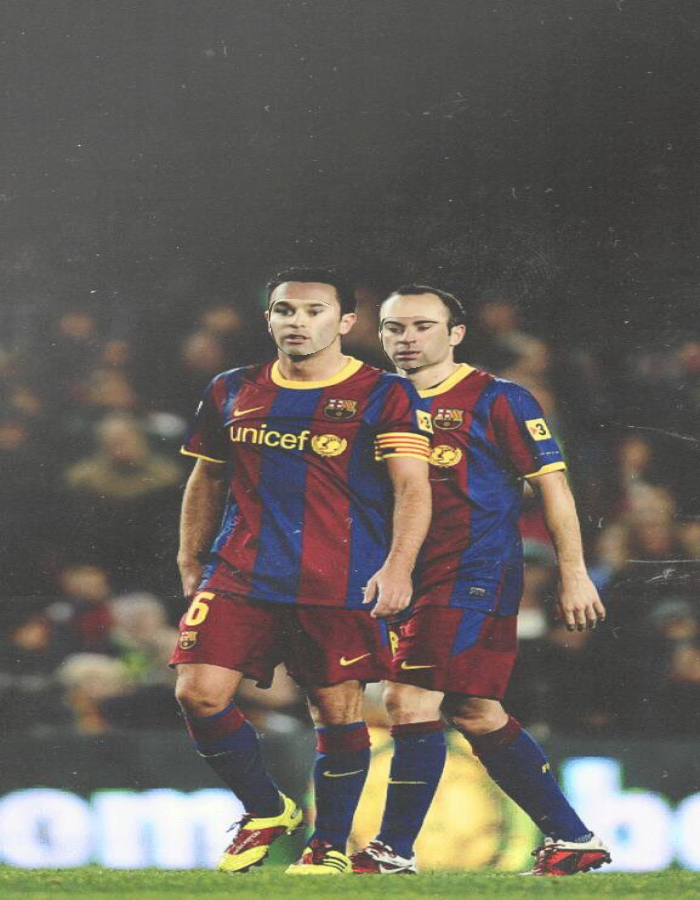

In [ ]:
base_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/IX.png")
# cv2_imshow(base_img)
base_img = cv2.resize(base_img,(700,900),interpolation = cv2.INTER_AREA)
img_features, face_landmarks_li, faces_rectangle, face_points=getFacialFeatures(base_img)
f1_points = face_points[0]
f2_points = face_points[1] 


Wx, Kx = TPS(f1_points,f2_points,'x')
Wy, Ky = TPS(f1_points,f2_points,'y')

Wx_2, Kx_2 = TPS(f2_points,f1_points,'x')
Wy_2, Ky_2 = TPS(f2_points,f1_points,'y')

maskFace1 = mask_from_points((base_img.shape[0],base_img.shape[1]), f1_points, erode_flag=0)
maskFace2 = mask_from_points((base_img.shape[0],base_img.shape[1]), f2_points, erode_flag=0)

point_matrix_face_1, point_matrix_face_2 = face_values(faces_rectangle, base_img)
Fx = FXtoY(point_matrix_face_1, point_matrix_face_2, f1_points, f1_points, Wx, 'onetotwo')
Fy = FXtoY(point_matrix_face_1, point_matrix_face_2, f1_points, f1_points, Wy, 'onetotwo')

Fx_2 = FXtoY(point_matrix_face_1, point_matrix_face_2, f2_points, f2_points, Wx_2, 'twotoone')
Fy_2 = FXtoY(point_matrix_face_1, point_matrix_face_2, f2_points, f2_points, Wy_2, 'twotoone')


zX, zY, zZ = Inter(Fx,Fy,point_matrix_face_1, maskFace1,Fx_2,Fy_2,point_matrix_face_2,maskFace2,base_img,faces_rectangle,f1_points,f2_points)